In [1]:
import numpy as np
import scipy as sp
from sympy import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec 
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import block_diag
from scipy.integrate import odeint
%config InlineBackend.figure_format = 'retina'
import pandas as pd

# SINDY 

In [2]:
#Define dynamical system
def Lorenz(y, t, sigma, rho, beta):
    dy = np.zeros_like(y)
    dy[0] = sigma*(y[1]-y[0])
    dy[1] = y[0]*(rho-y[2]) - y[1]
    dy[2] = y[0]*y[1] - beta*y[2]
    return dy

In [3]:
#chaotic parameters
sigma, rho, beta = 10., 28., 8./3.
#time 
t = np.linspace(0.001, 100, 100000)
#initial conditions
x0 = np.array([-8., 7., 27.])
#time series
x = odeint(Lorenz, x0, t, rtol=1e-12, atol=1e-12, args=(sigma, rho, beta))

In [4]:
#Derivative calculation as stated in the original paper, from the functions 
dx_analytical = np.zeros((x.shape))
for i in range(len(x)):
    dx_analytical[i,:] = Lorenz(x[i,:], 0, sigma, rho, beta)
#dx_analytical = dx_analytical + 0.2*np.random.randn(x.shape[0], x.shape[1])

In [5]:
#Numerical derivative
dx_diff = np.diff(x, axis=0)/0.001

In [6]:
#Numerical derivative from gradient function
dt = t[1] - t[0]
dx_grad = np.gradient(x, dt, axis=0) #returns the same shape of x

In [7]:
# Non-linear function library
library = PolynomialFeatures(degree=5, include_bias=True)
# include_bias parameter is for the feature in which all polynomial powers are zero - column of ones
Theta = library.fit_transform(x)
n_lib = library.n_output_features_

In [8]:
feature_library = pd.DataFrame(data=Theta, columns=library.get_feature_names())

In [9]:
feature_library.head()

,1,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2,...,x0 x1^3 x2,x0 x1^2 x2^2,x0 x1 x2^3,x0 x2^4,x1^5,x1^4 x2,x1^3 x2^2,x1^2 x2^3,x1 x2^4,x2^5
0,1.0,-8.000000,7.000000,27.000000,64.000000,-56.000000,-216.000000,49.000000,189.000000,729.000000,...,-74088.000000,-285768.000000,-1.102248e+06,-4.251528e+06,16807.000000,64827.000000,250047.000000,964467.000000,3.720087e+06,1.434891e+07
1,1.0,-7.850824,6.984579,26.872753,61.635432,-54.834696,-210.973249,48.784340,187.694862,722.144877,...,-71886.616018,-276579.502446,-1.064123e+06,-4.094151e+06,16622.681478,63954.783618,246062.246519,946709.936878,3.642410e+06,1.401396e+07
2,1.0,-7.703289,6.968347,26.747005,59.340664,-53.679194,-206.039912,48.557864,186.382418,715.402258,...,-69717.325352,-267599.984039,-1.027144e+06,-3.942546e+06,16430.430310,63065.857252,242069.274874,929148.296572,3.566403e+06,1.368913e+07
3,1.0,-7.557388,6.951353,26.622740,57.114114,-52.534074,-201.198373,48.321312,185.064068,708.770263,...,-67582.234192,-258830.784772,-9.912868e+05,-3.796494e+06,16231.056857,62162.744903,238074.876325,911794.465082,3.492049e+06,1.337407e+07
4,1.0,-7.413111,6.933643,26.499944,54.954220,-51.399866,-196.447032,48.075402,183.741142,702.247012,...,-65483.194292,-250272.622768,-9.565261e+05,-3.655782e+06,16025.342006,61247.842565,234085.376612,894659.489201,3.419332e+06,1.306847e+07


### Hard - tresholded sequential least squares solution

#### Analytical derivative 

In [10]:
%time
coeff_anal, residuals, rank, s = np.linalg.lstsq(Theta, dx_analytical, rcond=None)
treshold = 0.025
for k in range(10):
    coeff_anal, residuals, rank, s = np.linalg.lstsq(Theta, dx_analytical, rcond=None) 
    coeff_anal[np.abs(coeff_anal) < treshold] = 0

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [11]:
coeff_anal_df = pd.DataFrame(data=coeff_anal, columns=('x0','x1','x2'), index=library.get_feature_names())
print('Total number of possible coefficients:', coeff_anal.size)
print('Number of non-zero coefficients:', np.count_nonzero(coeff_anal))
print(coeff_anal_df.head(n=8))

Total number of possible coefficients: 168
Number of non-zero coefficients: 7
         x0    x1        x2
1       0.0   0.0  0.000000
x0    -10.0  28.0  0.000000
x1     10.0  -1.0  0.000000
x2      0.0   0.0 -2.666667
x0^2    0.0   0.0  0.000000
x0 x1   0.0   0.0  1.000000
x0 x2   0.0  -1.0  0.000000
x1^2    0.0   0.0  0.000000


In [12]:
Theta_ = Theta[:-1,:]

#### Numerical derivative from np.diff

In [13]:
%time
coeff_diff, residuals, rank, s = np.linalg.lstsq(Theta_, dx_diff, rcond=None)
treshold = 0.025
for k in range(10):
    coeff_diff, residuals, rank, s = np.linalg.lstsq(Theta_, dx_diff, rcond=None) 
    coeff_diff[np.abs(coeff_diff) < treshold] = 0

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [14]:
coeff_diff_df = pd.DataFrame(data=coeff_diff, columns=('x0','x1','x2'), index=library.get_feature_names())
print('Total number of possible coefficients:', coeff_diff.size)
print('Number of non-zero coefficients:', np.count_nonzero(coeff_diff))
print(coeff_diff_df.head(n=8))

Total number of possible coefficients: 168
Number of non-zero coefficients: 7
             x0         x1        x2
1      0.000000   0.000000  0.000000
x0    -9.811139  27.847816  0.000000
x1     9.945649  -0.860056  0.000000
x2     0.000000   0.000000 -2.663114
x0^2   0.000000   0.000000  0.000000
x0 x1  0.000000   0.000000  0.993378
x0 x2  0.000000  -0.993288  0.000000
x1^2   0.000000   0.000000  0.000000


#### Numerical derivative from np.gradient

In [15]:
%time
coeff_grad, residuals, rank, s = np.linalg.lstsq(Theta, dx_grad, rcond=None)
treshold = 0.025
for k in range(10):
    coeff_grad, residuals, rank, s = np.linalg.lstsq(Theta, dx_grad, rcond=None) 
    coeff_grad[np.abs(coeff_grad) < treshold] = 0

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs


In [16]:
coeff_grad_df = pd.DataFrame(data=coeff_grad, columns=('x0','x1','x2'), index=library.get_feature_names())
print('Total number of possible coefficients:', coeff_grad.size)
print('Number of non-zero coefficients:', np.count_nonzero(coeff_grad))
print(coeff_grad_df.head(n=8))

Total number of possible coefficients: 168
Number of non-zero coefficients: 8
             x0         x1        x2
1      0.000000   0.000000  0.000000
x0    -9.951847  28.027714 -0.046209
x1     9.976071  -1.013456  0.000000
x2     0.000000   0.000000 -2.667459
x0^2   0.000000   0.000000  0.000000
x0 x1  0.000000   0.000000  0.995020
x0 x2  0.000000  -1.005412  0.000000
x1^2   0.000000   0.000000  0.000000


### Comparison between analytical and numerical derivative calculations 

In [17]:
def sindy_model(x,t,library,coeffs):
    dxdt = np.zeros_like(x)
    library = PolynomialFeatures(degree=5, include_bias=True)
    Theta = library.fit_transform(x.reshape(1,-1))
    dx = np.dot(Theta, coeffs)
    return dx.flatten()

In [18]:
x_num_diff = odeint(sindy_model, x0, t, args=(library, coeff_diff))
x_ana = odeint(sindy_model, x0, t, args=(library, coeff_anal))
x_num_grad = odeint(sindy_model, x0, t, args=(library, coeff_grad))

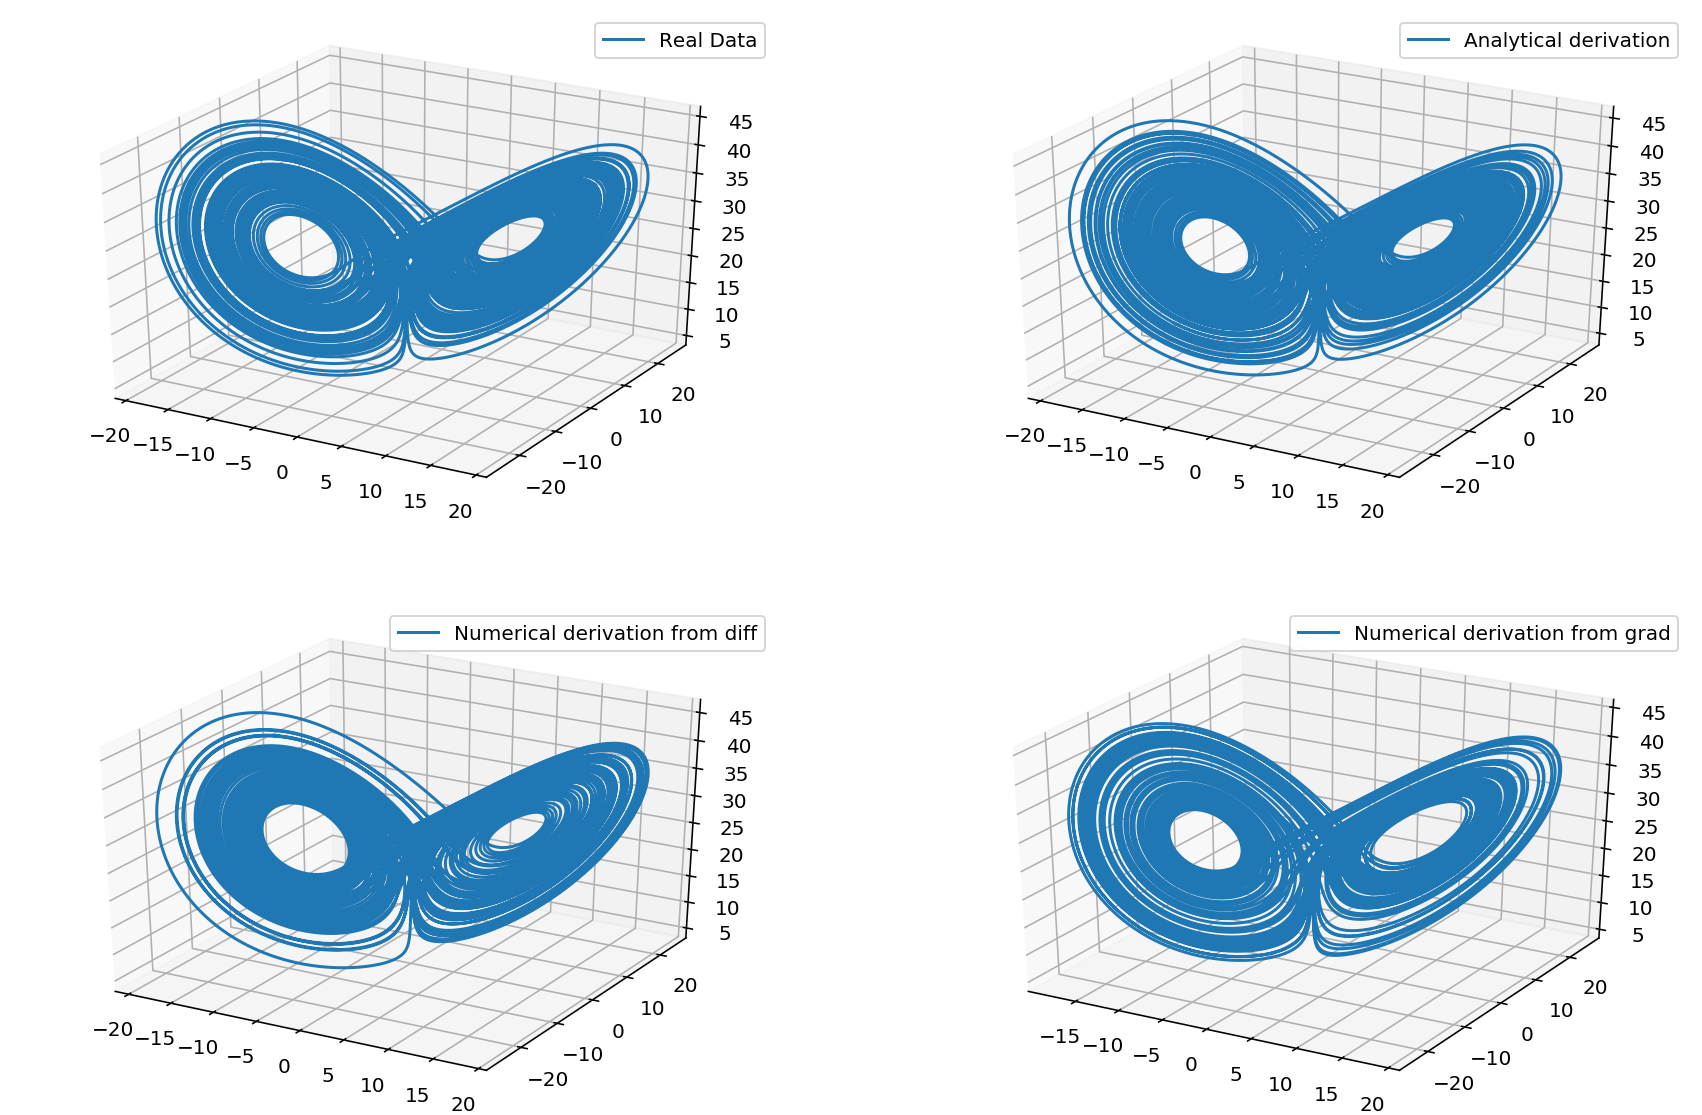

In [19]:
w = 10
fig = plt.figure(figsize=(1.5*w,w))
gs = GridSpec(ncols=2, nrows=2, figure=fig)

ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax1.plot(x[:,0],x[:,1],x[:,2], label='Real Data') #gt
plt.legend()

ax2 = fig.add_subplot(gs[0,1], projection='3d')
ax2.plot(x_ana[:,0], x_ana[:, 1], x_ana[:,2], label='Analytical derivation')
plt.legend()

ax3 = fig.add_subplot(gs[1,0], projection='3d')
ax3.plot(x_num_diff[:,0], x_num_diff[:, 1], x_num_diff[:,2], label='Numerical derivation from diff')
plt.legend()

ax4 = fig.add_subplot(gs[1,1], projection='3d')
ax4.plot(x_num_grad[:,0], x_num_grad[:, 1], x_num_grad[:,2], label='Numerical derivation from grad')
plt.legend()